# Face Recognition with OpenCV

* EigenFaces
* FisherFaces
* Local Binary Pattern
* Deep Neural Networks

## Setup Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

## Get Classifiers

In [2]:
# Get the classifiers
!wget https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_eye.xml
!wget https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_default.xml

--2023-02-03 15:08:58--  https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.02s   

2023-02-03 15:08:58 (13.9 MB/s) - ‘haarcascade_eye.xml’ saved [341406/341406]

--2023-02-03 15:08:58--  https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting 

## Create the dataset

In [3]:
import os

# Create the directory
output_folder = './data/me'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

### Helper Functions

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Setting up the Webcam

In [5]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Run the webcam

In [6]:
# Instantiate a face cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'

# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # get face bounding box for overlay
    for (x,y,w,h) in faces:
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        face_img = cv2.resize(gray[y:y+h, x:x+w], (200, 200))
        face_filename = '%s/%d.pgm' % (output_folder, count)
        cv2.imwrite(face_filename, face_img)
        count += 1

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

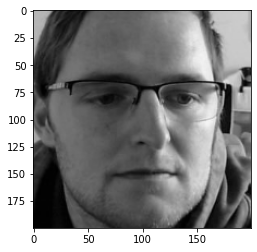

In [9]:
img = cv2.imread("data/me/0.pgm")
plt.imshow(img)

## Read Images from Directory

In [10]:
def read_images(path, sz=None):
    """Reads the images in a given folder, resizes images on the fly if size is given.
    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes
    Returns:
        A list [X,y]
            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    c = 0
    X,y = [], []
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                try:
                    if (filename == ".directory"):
                        continue
                    filepath = os.path.join(subject_path, filename)
                    im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)
                    if (im is None):
                        print("image " + filepath + " is none")
                    else:
                        print(filepath)
                    # resize to given size (if given)
                    if (sz is not None):
                        im = cv2.resize(im, (200, 200))

                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
                except IOError: # , (errno, strerror):
                    pass
                    # print("I/O error({0}): {1}").format(errno, strerror)
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            print(c)
            c = c+1
            

    print(y)
    return [X,y]

In [84]:
[X_train, y_train] = read_images("data")
y_train = np.asarray(y_train, dtype=np.int32)

data/me/0.pgm
data/me/20.pgm
data/me/7.pgm
data/me/21.pgm
data/me/2.pgm
data/me/13.pgm
data/me/8.pgm
data/me/14.pgm
data/me/12.pgm
data/me/4.pgm
data/me/16.pgm
data/me/3.pgm
data/me/15.pgm
data/me/19.pgm
data/me/5.pgm
data/me/11.pgm
data/me/22.pgm
data/me/6.pgm
data/me/18.pgm
data/me/10.pgm
data/me/1.pgm
data/me/9.pgm
data/me/17.pgm
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
names = ['Ryan', "Other"]

## EigenFaces Recognition

In [97]:
# Setup the model
e_model = cv2.face.EigenFaceRecognizer.create()
e_model

< cv2.face.EigenFaceRecognizer 0x7f6781aba050>

In [98]:
# Train the Model
e_model.train(np.asarray(X_train[:-1]), np.asarray(y_train[:-1]))

In [99]:
[p_label, p_confidence] = e_model.predict(np.asarray(X_train[-1]))
p_label, p_confidence

(0, 311.37584087234137)

## FisherFaces Recognition

This will error out if you do not have more than two class variables

In [107]:
# Setup the model
f_model = cv2.face.FisherFaceRecognizer.create(10)
f_model

# Train the Model
f_model.train(np.asarray(X_train[:-1]), np.asarray(y_train[:-1]))

[p_label, p_confidence] = f_model.predict(np.asarray(X_train[-1]))
p_label, p_confidence

error: ignored

## Local Binary Pattern

In [96]:
# Setup the model
l_model = cv2.face.LBPHFaceRecognizer.create()
l_model

# Train the Model
l_model.train(np.asarray(X_train[:-1]), np.asarray(y_train[:-1]))

[p_label, p_confidence] = l_model.predict(np.asarray(X_train[-1]))
p_label, p_confidence

(0, 20.17103435147199)

### Test with Random Photo

In [24]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


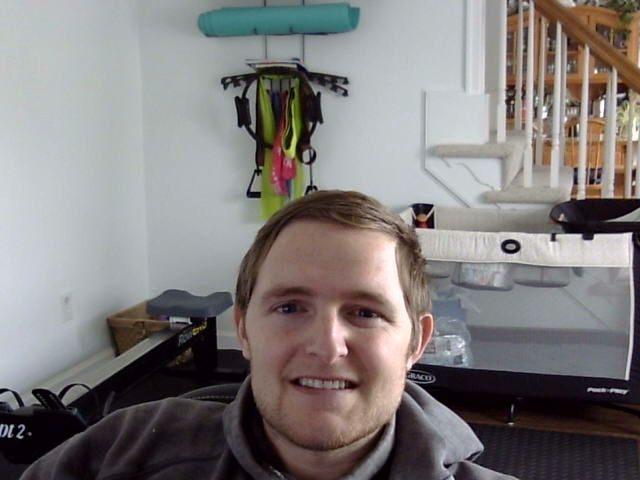

In [51]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

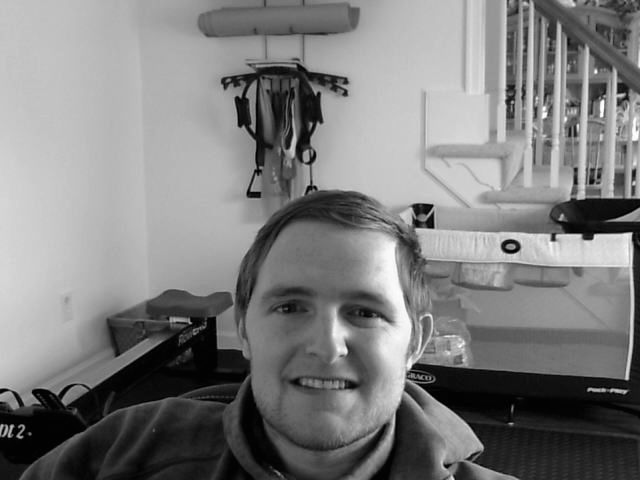

In [67]:
from google.colab.patches import cv2_imshow

# Take random photo
img = cv2.imread('photo.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

## Create Helper function for Model Detection

In [104]:
def model_detect(photo_name, model):
    """
    Perform a model detection within the current frame
    """
    # Take random photo
    img = cv2.imread(photo_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(gray)

    # Instantiate a face cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detection
    faces = face_cascade.detectMultiScale(gray, 1.3, 5, minSize=(120, 120))

    for (x, y, w, h) in faces:
        # Get smaller bounding box
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0), 2)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Pull out region of interest
        roi = gray[x:x+w, y:y+h]
        roi = cv2.resize(roi, (200, 200), interpolation=cv2.INTER_LINEAR)
        # print(roi.shape)

        # Make Predictions
        params = model.predict(roi)
        print("Label: %s, Confidence: %.2f" % (params[0], params[1]))
        cv2.putText(img, names[params[0]], (x,y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

    cv2_imshow(img)

## Test Each Model

Label: 0, Confidence: 5258.38


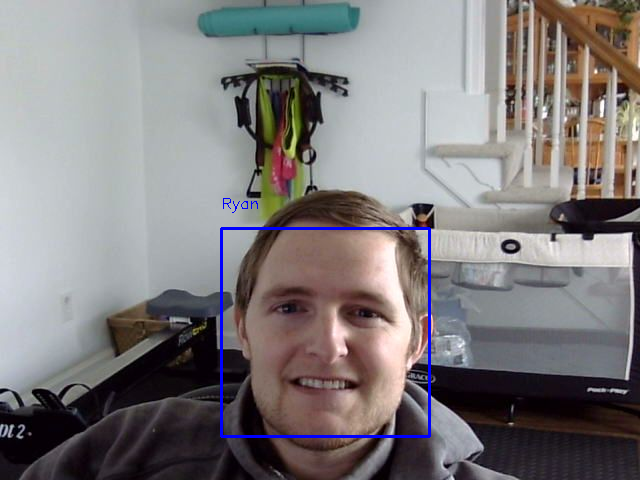

In [105]:
model_detect('photo.jpg', e_model)

In [ ]:
# Need extra training label
model_detect('photo.jpg', f_model)

Label: 0, Confidence: 45.25


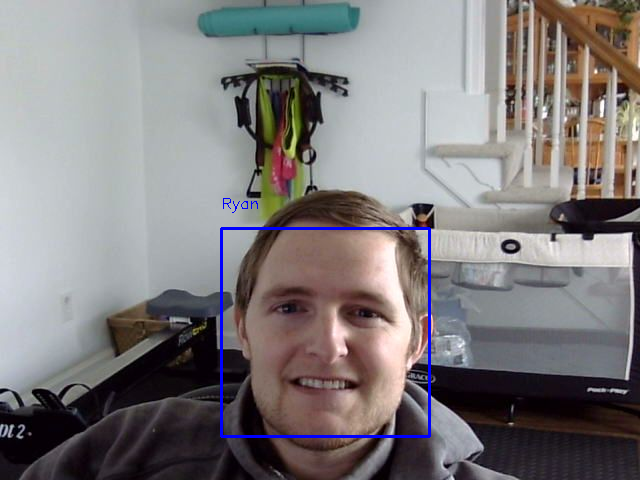

In [106]:
model_detect('photo.jpg', l_model)

Concludes the Face Recognition Notebook

- Create a Python CLI
- Create a C++ CLI